In [1]:
import sys 
sys.path.append('../scripts/')
from kf import *   #誤差楕円を描くのに利用

In [2]:
def draw(xs, Rs):  ###graphslam3draw
    ##世界の描画##
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111) 
    ax.set_aspect('equal')
    ax.set_xlim(-5,5)
    ax.set_ylim(-5,5) 
    ax.set_xlabel("X",fontsize=10) 
    ax.set_ylabel("Y",fontsize=10)  
    
    ##軌跡の描画##
    poses = [xs[s] for s in range(len(hat_xs))]
    ax.scatter([e[0] for e in poses], [e[1] for e in poses], s=5, marker=".", color="black")
    ax.plot([e[0] for e in poses], [e[1] for e in poses], linewidth=0.5, color="black")
    
    ##R_tの描画##  #追加
    for t in range(1,t_end+1):
        ax.add_patch( sigma_ellipse(xs[t], Rs[t], 3) )
    
    ##描画実行##
    plt.show()

In [3]:
###データの読み込み###
delta = 0.0
xs = {}     #軌跡のデータ（ステップ数をキーにして姿勢を保存）
us = {}    #制御入力のデータ（ステップ数をキーにして保存）

with open("log.txt") as f:
    for line in f.readlines():
        tmp = line.rstrip().split()
        
        step = float(tmp[1])
        if tmp[0] == "delta":
            delta = float(tmp[1])
        elif tmp[0] == "x": #姿勢のレコードの場合
            xs[step] = np.array([float(tmp[2]), float(tmp[3]), float(tmp[4])]).T
        elif tmp[0] == "u": #制御入力の場合
            us[step] = np.array([float(tmp[2]), float(tmp[3])]).T
            
import copy
hat_xs = copy.copy(xs)

In [4]:
##空の精度行列と一次の項のベクトルの準備## 
t_end = len(xs) - 1 #step数（数式中のT）
#t_end = 1

##精度行列の次元を求めて精度行列と一次の項のベクトルの初期化##
dim = (t_end + 1)*3# + len(observed_landmarks)*2
Omega = np.zeros((dim, dim))
xi = np.zeros((dim, 1))

##確認##
print(t_end)                           #終了時刻
print(Omega)                        #精度行列
print(xi)                                  #一次の項のベクトル

31
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [5]:
##Ω_0を作る## ###graphslam3omzero
alpha = 0.001
Sigma_0 = np.diag([0.001**2, 0.001**2, 0.001**2])

Om_0 = np.linalg.inv(Sigma_0) #3x3の精度行列としてΩ0を作る
xi_0 = Om_0.dot(xs[0])

print("Ω0 = ", Om_0)
print("ξ0 =", xi_0)

Ω0 =  [[1000000.       0.       0.]
 [      0. 1000000.       0.]
 [      0.       0. 1000000.]]
ξ0 = [0. 0. 0.]


In [6]:
##Ωxx,ξxxを作る##   ###graphslam3motioninfo
motion_noise_stds = {"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}

def R(t): #R_tを返す
    theta = xs[t-1][2]
    nu, om = us[t]
#    if abs(om) < 1e-5: om = 1e-5 #ゼロにすると式が変わるので避ける
#    if abs(nu) < 1e-5:         nu = 1e-5
        
    st, ct = math.sin(theta), math.cos(theta)
    stw, ctw = math.sin(theta + om*delta), math.cos(theta + om*delta)
    A = np.array([[(stw - st)/om,    -nu/(om**2)*(stw - st) + nu/om*delta*ctw],
                                 [(-ctw + ct)/om, -nu/(om**2)*(-ctw + ct) + nu/om*delta*stw],
                                 [0,                                delta]] )
    M = np.diag(
        [motion_noise_stds["nn"]**2*abs(nu)/delta +motion_noise_stds["no"]**2*abs(om)/delta,
             motion_noise_stds["on"]**2*abs(nu)/delta + motion_noise_stds["oo"]**2*abs(om)/delta]
    )
    return A.dot(M).dot(A.T) + np.diag([0.01**2, 0.01**2, 0.01**2]) #xyθ方向に誤差を混ぜておく
    #return np.diag([0.1**2, 0.1**2, 0.1**2]) 

def F(t): #F_x_{t-1}を返す（添字注意）
    F = np.array(np.eye(3))
    theta = xs[t-1][2]
    nu, om = us[t]
#    if abs(om) < 1e-5: om = 1e-5 #ゼロにすると式が変わるので避ける
#    if abs(nu) < 1e-5:         nu = 1e-5
    
    F[0, 2] = nu / om * (math.cos(theta + om * delta) - math.cos(theta))
    F[1, 2] = nu / om * (math.sin(theta + om * delta) - math.sin(theta))
        
    return F

##必要な行列を先に計算##
Rs, Fs, Rinvs = {}, {}, {}
for t in range(1, t_end+1):
    Rs[t] = R(t)
    Rinvs[t] = np.linalg.inv(Rs[t])
    Fs[t-1] = F(t)
    
##各x_{t-1}, x_tペアの精度行列と一次の項のベクトルを作る##
Omxx_ul, Omxx_ur, Omxx_bl, Omxx_br = {}, {}, {}, {} #x_{t-1}とx_tに対する精度行列を保管する辞書
xixx_u, xixx_b = {}, {}

import copy

for t in range(1, t_end+1):
    Omxx_ul[(t-1, t)] = Fs[t-1].T.dot(Rinvs[t]).dot(Fs[t-1])
    Omxx_ur[(t-1, t)] = -Fs[t-1].T.dot(Rinvs[t])
    Omxx_bl[(t-1, t)] = -Rinvs[t].dot(Fs[t-1].T)
    Omxx_br[(t-1, t)] = copy.copy(Rinvs[t])
    
    xixx_b[(t-1, t)] = Rinvs[t].dot(hat_xs[t]- Fs[t-1].dot(xs[t-1])) #下の3行から計算
    xixx_u[(t-1, t)] = - Fs[t-1].T.dot(xixx_b[(t-1, t)])

In [7]:
Omega = np.zeros((dim, dim))
xi = np.zeros((dim, 1))

Omega[0:3, 0:3] += Om_0
xi[0:3, 0] += xi_0

for t in range(1, t_end+1):
    Omega[(t-1)*3:t*3, (t-1)*3:t*3] +=  Omxx_ul[(t-1, t)]
    Omega[(t-1)*3:t*3, t*3:(t+1)*3] +=  Omxx_ur[(t-1, t)]
    Omega[t*3:(t+1)*3, (t-1)*3:t*3] +=  Omxx_bl[(t-1, t)]
    Omega[t*3:(t+1)*3, t*3:(t+1)*3] +=  Omxx_br[(t-1, t)]
    
    xi[(t-1)*3:t*3, 0] += xixx_u[(t-1, t)]
    xi[t*3:(t+1)*3, 0] += xixx_b[(t-1, t)]
    
xx = np.zeros((dim, 1))
for t in range(t_end+1):
    xx[t*3:t*3+3, 0] += xs[t]
xi = Omega.dot(xx) 

[0.59316956 0.07809225 0.26179939]
[0.59316956 0.07809225 0.26179939]


<IPython.core.display.Javascript object>


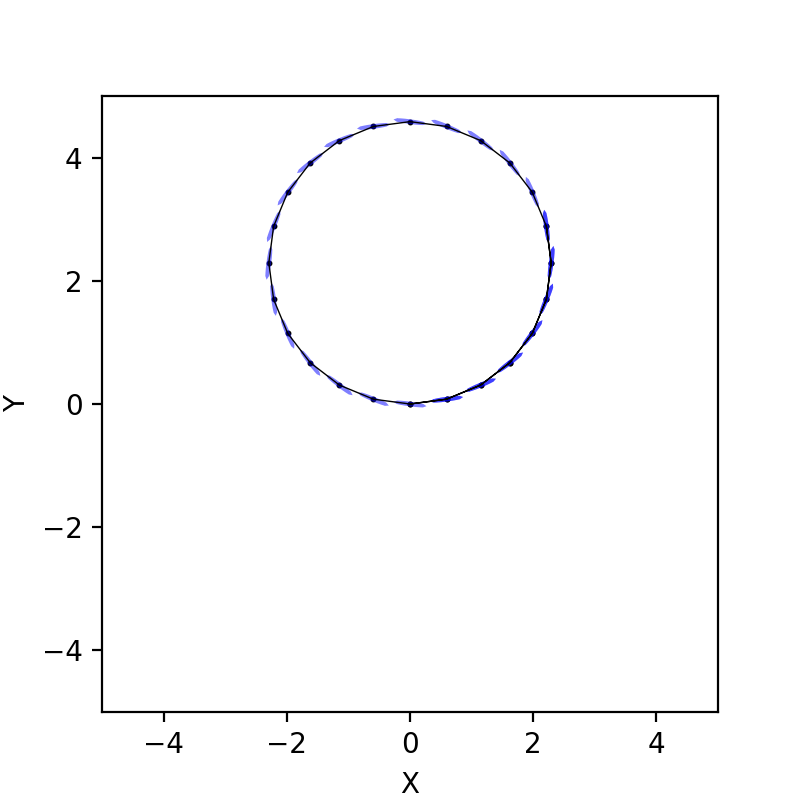

In [8]:
A = Omega[0:(t_end+1)*3 , 0:(t_end+1)*3 ]
b = xi[0:(t_end+1)*3, 0]

#A = Omega[0:6 , 0:6 ]
#b = xi[0:6, 0]

print(hat_xs[1])

c = np.linalg.inv(A).dot(b)
for t in range(1,t_end+1):
    hat_xs[t] = c[t*3:t*3+3]
    
print(hat_xs[1])
    
draw(hat_xs, Rs)

In [9]:
np.linalg.inv(A).dot(b)

array([ 3.03576608e-17,  1.02999206e-17,  1.03541307e-17,  5.93169558e-01,
        7.80922538e-02,  2.61799388e-01,  1.14591559e+00,  3.07047157e-01,
        5.23598776e-01,  1.62056937e+00,  6.71261811e-01,  7.85398163e-01,
        1.98478402e+00,  1.14591559e+00,  1.04719755e+00,  2.21373893e+00,
        1.69866162e+00,  1.30899694e+00,  2.29183118e+00,  2.29183118e+00,
        1.57079633e+00,  2.21373893e+00,  2.88500074e+00,  1.83259571e+00,
        1.98478402e+00,  3.43774677e+00,  2.09439510e+00,  1.62056937e+00,
        3.91240055e+00,  2.35619449e+00,  1.14591559e+00,  4.27661520e+00,
        2.61799388e+00,  5.93169558e-01,  4.50557011e+00,  2.87979327e+00,
       -2.04636308e-12,  4.58366236e+00,  3.14159265e+00, -5.93169558e-01,
        4.50557011e+00,  3.40339204e+00, -1.14591559e+00,  4.27661520e+00,
        3.66519143e+00, -1.62056937e+00,  3.91240055e+00,  3.92699082e+00,
       -1.98478402e+00,  3.43774677e+00,  4.18879020e+00, -2.21373893e+00,
        2.88500074e+00,  

In [10]:
Fs[0].dot(hat_xs[0])

array([0., 0., 0.])

In [11]:
hat_xs[1]

array([0.59316956, 0.07809225, 0.26179939])

In [12]:
0.08726646/3.14*180

5.002535923566879

In [13]:
hat_xs[2]

array([1.14591559, 0.30704716, 0.52359878])

In [14]:
Fs

{0: array([[ 1.        ,  0.        , -0.07809225],
        [ 0.        ,  1.        ,  0.59316956],
        [ 0.        ,  0.        ,  1.        ]]),
 1: array([[ 1.        ,  0.        , -0.2289549 ],
        [ 0.        ,  1.        ,  0.55274603],
        [ 0.        ,  0.        ,  1.        ]]),
 2: array([[ 1.        ,  0.        , -0.36421465],
        [ 0.        ,  1.        ,  0.47465378],
        [ 0.        ,  0.        ,  1.        ]]),
 3: array([[ 1.        ,  0.        , -0.47465378],
        [ 0.        ,  1.        ,  0.36421465],
        [ 0.        ,  0.        ,  1.        ]]),
 4: array([[ 1.        ,  0.        , -0.55274603],
        [ 0.        ,  1.        ,  0.2289549 ],
        [ 0.        ,  0.        ,  1.        ]]),
 5: array([[ 1.        ,  0.        , -0.59316956],
        [ 0.        ,  1.        ,  0.07809225],
        [ 0.        ,  0.        ,  1.        ]]),
 6: array([[ 1.        ,  0.        , -0.59316956],
        [ 0.        ,  1.        , -

In [15]:
c

array([ 3.03576608e-17,  1.02999206e-17,  1.03541307e-17,  5.93169558e-01,
        7.80922538e-02,  2.61799388e-01,  1.14591559e+00,  3.07047157e-01,
        5.23598776e-01,  1.62056937e+00,  6.71261811e-01,  7.85398163e-01,
        1.98478402e+00,  1.14591559e+00,  1.04719755e+00,  2.21373893e+00,
        1.69866162e+00,  1.30899694e+00,  2.29183118e+00,  2.29183118e+00,
        1.57079633e+00,  2.21373893e+00,  2.88500074e+00,  1.83259571e+00,
        1.98478402e+00,  3.43774677e+00,  2.09439510e+00,  1.62056937e+00,
        3.91240055e+00,  2.35619449e+00,  1.14591559e+00,  4.27661520e+00,
        2.61799388e+00,  5.93169558e-01,  4.50557011e+00,  2.87979327e+00,
       -2.04636308e-12,  4.58366236e+00,  3.14159265e+00, -5.93169558e-01,
        4.50557011e+00,  3.40339204e+00, -1.14591559e+00,  4.27661520e+00,
        3.66519143e+00, -1.62056937e+00,  3.91240055e+00,  3.92699082e+00,
       -1.98478402e+00,  3.43774677e+00,  4.18879020e+00, -2.21373893e+00,
        2.88500074e+00,  

In [16]:
Omega

array([[ 1.00020183e+06, -1.18213307e+03, -3.59618410e+02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.18213307e+03,  1.00902666e+06,  2.73655790e+03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-3.59618410e+02,  2.73655790e+03,  1.00087794e+06, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         9.02666362e+03,  1.18213307e+03,  2.71009960e+03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.18213307e+03,  2.01826495e+02,  3.57348028e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         2.71009960e+03,  3.57348028e+02,  8.62067681e+02]])

In [17]:
xi

array([[  -120.95539178],
       [   705.79526259],
       [   202.08296551],
       [  -728.91566103],
       [  1273.40851828],
       [   860.41814451],
       [ -1812.2199669 ],
       [  1948.45267607],
       [  1372.59965411],
       [ -3097.87090285],
       [  1900.50746229],
       [  1959.2037829 ],
       [ -4263.95053843],
       [  1163.29091631],
       [  2609.71606362],
       [ -5062.72191846],
       [  -116.30736388],
       [  3309.26679407],
       [ -5348.97146872],
       [ -1733.54984503],
       [  4039.64438274],
       [ -5076.72128532],
       [ -3481.34791507],
       [  4780.53643868],
       [ -4270.62403873],
       [ -5190.33323015],
       [  5510.91402735],
       [ -2985.14044418],
       [ -6743.81712241],
       [  6210.4647578 ],
       [ -1267.32560651],
       [ -8066.38782583],
       [  6860.97703852],
       [   862.97104233],
       [ -9093.43183214],
       [  7447.58116731],
       [  3407.82546572],
       [ -9735.07138356],
       [  79

In [18]:
import seaborn

<IPython.core.display.Javascript object>


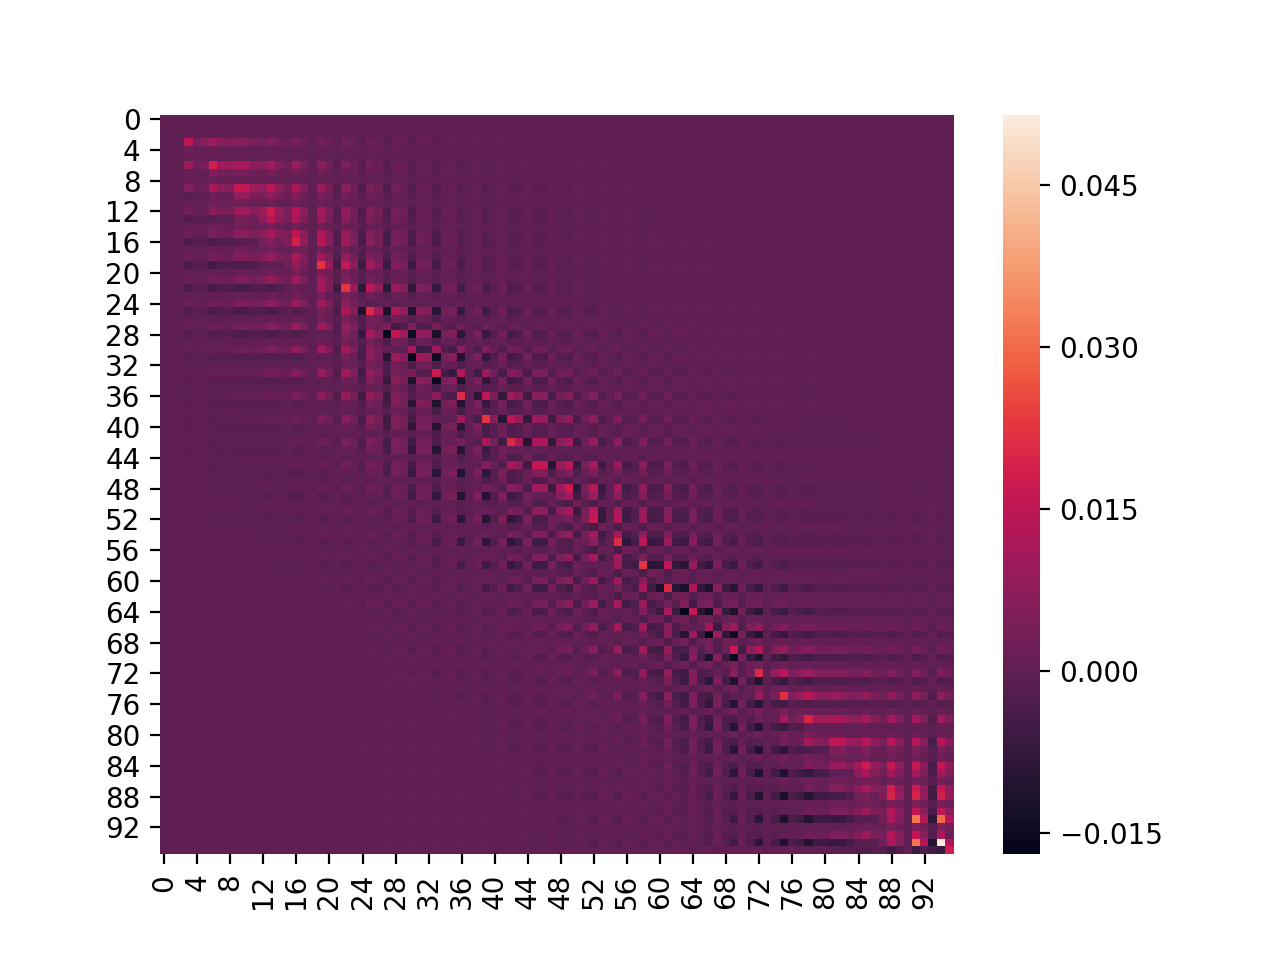

In [19]:
seaborn.heatmap(np.linalg.inv(Omega))
plt.show()

In [20]:
np.linalg.inv(Omega)

array([[ 9.99955590e-07,  2.39013488e-10,  7.33442631e-10, ...,
        -5.59733059e-11,  2.09260363e-10,  9.40592458e-11],
       [ 2.18392662e-10,  9.98334850e-07, -5.49438356e-09, ...,
        -9.75936317e-12,  3.64861043e-11,  1.63999307e-11],
       [ 7.02125683e-11, -5.13403719e-10,  9.98291148e-07, ...,
        -5.89398489e-12,  2.20351004e-11,  9.90443149e-12],
       ...,
       [ 1.68938451e-10, -4.29243473e-10,  2.33899790e-10, ...,
        -1.75747174e-03,  1.26743284e-02,  8.07452979e-04],
       [ 6.31764276e-10,  3.65547187e-10,  2.84011470e-10, ...,
        -1.04188061e-02,  5.15094002e-02,  1.23068973e-02],
       [-7.88768757e-11,  1.20991038e-10, -8.54025444e-11, ...,
        -4.75622800e-03, -7.09244802e-03,  1.82948472e-02]])

In [21]:
xx = np.zeros((dim, 1))
for t in range(t_end+1):
    xx[t*3:t*3+3, 0] += xs[t]
Omega.dot(xx) 

array([[  -120.95539178],
       [   705.79526259],
       [   202.08296551],
       [  -728.91566103],
       [  1273.40851828],
       [   860.41814451],
       [ -1812.2199669 ],
       [  1948.45267607],
       [  1372.59965411],
       [ -3097.87090285],
       [  1900.50746229],
       [  1959.2037829 ],
       [ -4263.95053843],
       [  1163.29091631],
       [  2609.71606362],
       [ -5062.72191846],
       [  -116.30736388],
       [  3309.26679407],
       [ -5348.97146872],
       [ -1733.54984503],
       [  4039.64438274],
       [ -5076.72128532],
       [ -3481.34791507],
       [  4780.53643868],
       [ -4270.62403873],
       [ -5190.33323015],
       [  5510.91402735],
       [ -2985.14044418],
       [ -6743.81712241],
       [  6210.4647578 ],
       [ -1267.32560651],
       [ -8066.38782583],
       [  6860.97703852],
       [   862.97104233],
       [ -9093.43183214],
       [  7447.58116731],
       [  3407.82546572],
       [ -9735.07138356],
       [  79

In [22]:
xi

array([[  -120.95539178],
       [   705.79526259],
       [   202.08296551],
       [  -728.91566103],
       [  1273.40851828],
       [   860.41814451],
       [ -1812.2199669 ],
       [  1948.45267607],
       [  1372.59965411],
       [ -3097.87090285],
       [  1900.50746229],
       [  1959.2037829 ],
       [ -4263.95053843],
       [  1163.29091631],
       [  2609.71606362],
       [ -5062.72191846],
       [  -116.30736388],
       [  3309.26679407],
       [ -5348.97146872],
       [ -1733.54984503],
       [  4039.64438274],
       [ -5076.72128532],
       [ -3481.34791507],
       [  4780.53643868],
       [ -4270.62403873],
       [ -5190.33323015],
       [  5510.91402735],
       [ -2985.14044418],
       [ -6743.81712241],
       [  6210.4647578 ],
       [ -1267.32560651],
       [ -8066.38782583],
       [  6860.97703852],
       [   862.97104233],
       [ -9093.43183214],
       [  7447.58116731],
       [  3407.82546572],
       [ -9735.07138356],
       [  79